# Esercizio 1: Classification Iris

dataset: https://archive.ics.uci.edu/ml/datasets/iris

In [72]:
from sklearn import tree 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score 
import graphviz 
from imblearn.over_sampling import SMOTE
from collections import Counter
from itertools import repeat
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

##### load the dataset and split it in train and test set

In [4]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=1)

##### Initialize the model and fit with the training data

In [5]:
# the weights are the same for all the classes
clf = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:1}) 
clf = clf.fit(X_train, y_train)

##### Predict the classes of the test set

In [6]:
predicted_y_test = clf.predict(X_test)

##### Printing information about the model

In [7]:
print(f"predicted classes:\n{predicted_y_test}\n")
print(f"real classes:\n{y_test}")
print(f"\ncorrectly classified examples: {sum(predicted_y_test == y_test)}")
print(f"number of errors: {sum(predicted_y_test != y_test)}")

predicted classes:
[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 2 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0 1 2 2 0 1 2 1]

real classes:
[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 1 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0 1 2 2 0 2 2 1]

correctly classified examples: 43
number of errors: 2


In [8]:
for i in range(len(y_test)):
    print(f"class {iris.target_names[y_test[i]]} predicted as {iris.target_names[predicted_y_test[i]]}")
    for j in range(len(iris.feature_names)):
        print(f"{iris.feature_names[j]}: {X_test[i][j]}")
    print("\n")

class setosa predicted as setosa
sepal length (cm): 5.8
sepal width (cm): 4.0
petal length (cm): 1.2
petal width (cm): 0.2


class versicolor predicted as versicolor
sepal length (cm): 5.1
sepal width (cm): 2.5
petal length (cm): 3.0
petal width (cm): 1.1


class versicolor predicted as versicolor
sepal length (cm): 6.6
sepal width (cm): 3.0
petal length (cm): 4.4
petal width (cm): 1.4


class setosa predicted as setosa
sepal length (cm): 5.4
sepal width (cm): 3.9
petal length (cm): 1.3
petal width (cm): 0.4


class virginica predicted as virginica
sepal length (cm): 7.9
sepal width (cm): 3.8
petal length (cm): 6.4
petal width (cm): 2.0


class versicolor predicted as versicolor
sepal length (cm): 6.3
sepal width (cm): 3.3
petal length (cm): 4.7
petal width (cm): 1.6


class virginica predicted as virginica
sepal length (cm): 6.9
sepal width (cm): 3.1
petal length (cm): 5.1
petal width (cm): 2.3


class setosa predicted as setosa
sepal length (cm): 5.1
sepal width (cm): 3.8
petal lengt

##### Accuracy and F1 of the model 
- F1 = 2 * (precision * recall) / (precision + recall)

In [9]:
print(f"accuracy: {accuracy_score(y_test, predicted_y_test)}")
f1 = f1_score(y_test, predicted_y_test, average='macro') # macro means that the score is calculated for each class and then averaged
print(f"f1 score: {f1}")

accuracy: 0.9555555555555556
f1 score: 0.9558404558404558


##### Cross Validation

In [10]:
#cross validation
accuracy_scores = cross_val_score(clf, iris.data, iris.target, cv=5) # default score is the accuracy, 5-fold cross validation
print(f"cross validation scores: {accuracy_scores}")
f1_scores = cross_val_score(clf, iris.data, iris.target, cv=5, scoring='f1_macro') 
print(f"cross validation f1 scores: {f1_scores}")

cross validation scores: [0.96666667 1.         0.86666667 0.86666667 1.        ]
cross validation f1 scores: [0.96658312 1.         0.86111111 0.86666667 1.        ]


##### Visualize the Tree with Graphviz

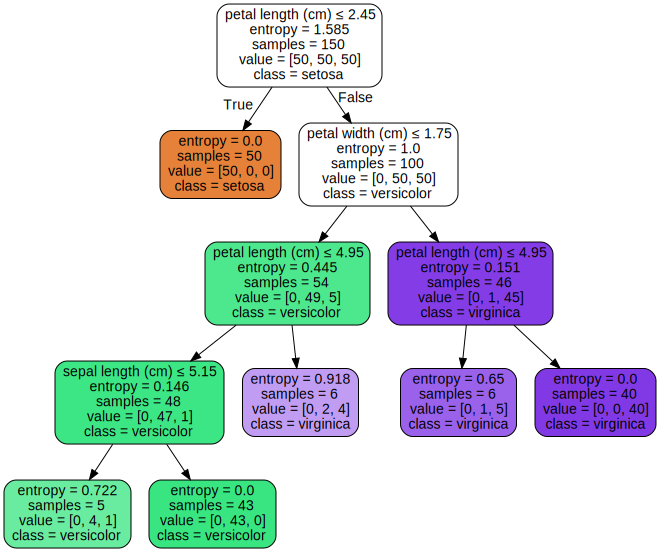

In [11]:
# initialize another classifier to visualize the graph on the total examples
clf_graph = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:1})
clf_graph = clf_graph.fit(iris.data, iris.target)

dot_data = tree.export_graphviz(clf_graph, out_file=None, 
                                feature_names=iris.feature_names,
                                class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

- The maximum entropy is log2(3) = 1.585
- The minimum entropy is 0
- The class is chosen by the majority of the samples

### 1 Oversampling (Artificial Inflation)

Applicate un sovracampionamento (artificial inflation) ad una classe nel training set con un determinato fattore: 10 (si pesi di più una delle classi tra virginica o versicolor che sono più difficili da discriminare). Si apprenda l'albero di decisione in queste condizioni.

In [90]:
def oversampling(X_train, y_train, oversampling_factor):
	X_train_augmented = []
	y_train_augmented = []
	for (x,y) in zip(X_train, y_train):
		if y == 2:
			X_train_augmented.extend(repeat(x, oversampling_factor))
			y_train_augmented.extend(repeat(y, oversampling_factor))
		else:
			X_train_augmented.append(x)
			y_train_augmented.append(y)
	return X_train_augmented, y_train_augmented

def oversampling_list(X_train, y_train, oversampling_factor):
	X_train_augmented = []
	y_train_augmented = []
	for (x,y) in zip(X_train, y_train):
		if 2 in y:
			X_train_augmented.extend(repeat(x, oversampling_factor))
			y_train_augmented.extend(repeat(y, oversampling_factor))
		else:
			X_train_augmented.append(x)
			y_train_augmented.append(y)
	return X_train_augmented, y_train_augmented

def compute_fp_tp_fn_tn(real_value, predicted_value, positive_class):
	# returns tuple (fp, tp, fn, tn)
	fp, tp, fn, tn = 0, 0, 0, 0
	for i in range(len(real_value)):
		if real_value[i] == positive_class and predicted_value[i] == positive_class:
			tp += 1
		elif real_value[i] != positive_class and predicted_value[i] == positive_class:
			fp += 1
		elif real_value[i] == positive_class and predicted_value[i] != positive_class:
			fn += 1
		elif real_value[i] != positive_class and predicted_value[i] != positive_class:
			tn += 1
	return fp, tp, fn, tn

#### Starting Tree

In [65]:
clf =  tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=30,class_weight={0:1,1:1,2:1},max_depth=2)
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=1)

clf = clf.fit(X_train, y_train)
predicted_y_test = clf.predict(X_test)

fp, tp, fn, tn = 0, 0, 0, 0
for i in range(0,3):
	fp, tp, fn, tn = compute_fp_tp_fn_tn(y_test, predicted_y_test, i)
	print(f"accuracy_homemade for class {i}: {(tp+tn) / (tp+tn+fp+fn)}")
	print(f"precision for class {i}: {tp / (tp+fp)}")
	print(f"recall for class {i} : {tp / (tp+fn)}")
	print('\n')

print(f"accuracy: {accuracy_score(y_test, predicted_y_test)}")

f1 = f1_score(y_test, predicted_y_test, average='macro') # macro means that the score is calculated for each class and then averaged
print(f"f1 score: {f1}")

confusion_matrix(y_test, predicted_y_test)

accuracy_homemade for class 0: 1.0
precision for class 0: 1.0
recall for class 0 : 1.0


accuracy_homemade for class 1: 0.9555555555555556
precision for class 1: 0.9444444444444444
recall for class 1 : 0.9444444444444444


accuracy_homemade for class 2: 0.9555555555555556
precision for class 2: 0.9230769230769231
recall for class 2 : 0.9230769230769231


accuracy: 0.9555555555555556
f1 score: 0.9558404558404558


array([[14,  0,  0],
       [ 0, 17,  1],
       [ 0,  1, 12]], dtype=int64)

Schema one-vs-rest

In [71]:
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:1}))

y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

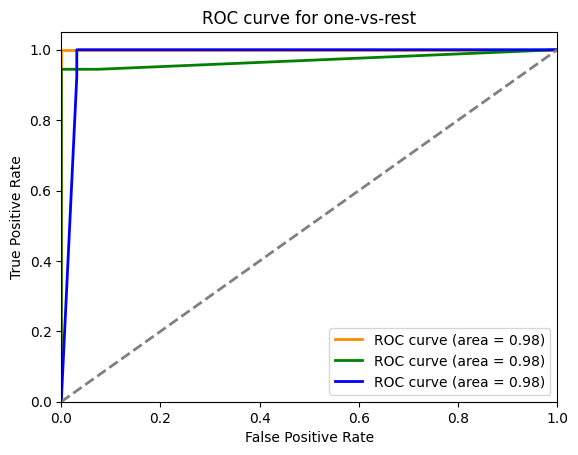

In [106]:
plt.figure()
lw = 2

plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)

plt.plot(
    fpr[1],
    tpr[1],
    color="green",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)

plt.plot(
    fpr[2],
    tpr[2],
    color="blue",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)

plt.plot([0, 1], [0, 1], color="grey", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for one-vs-rest")
plt.legend(loc="lower right")
plt.show()

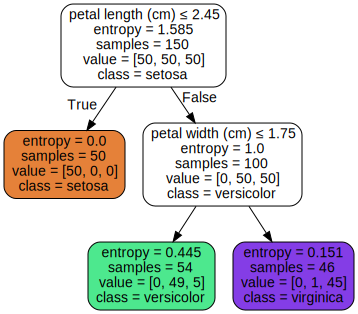

In [27]:
clf_graph = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=30,class_weight={0:1,1:1,2:1})
clf_graph = clf_graph.fit(iris.data, iris.target)

dot_data = tree.export_graphviz(clf_graph, out_file=None, 
                                feature_names=iris.feature_names,
                                class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Oversampling Tree

In [56]:
OVERSAMPLING_FACTOR = 10

clf_oversampling = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:1})

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=1)

X_train_oversample, y_train_oversample = oversampling(X_train, y_train, OVERSAMPLING_FACTOR)

clf_oversampling = clf_oversampling.fit(X_train_oversample, y_train_oversample)

predicted_y_test = clf_oversampling.predict(X_test)

fp, tp, fn, tn = 0, 0, 0, 0
for i in range(0,3):
	fp, tp, fn, tn = compute_fp_tp_fn_tn(y_test, predicted_y_test, i)
	print(f"accuracy_homemade for class {i}: {(tp+tn) / (tp+tn+fp+fn)}")
	print(f"precision for class {i}: {tp / (tp+fp)}")
	print(f"recall for class {i} : {tp / (tp+fn)}")
	print('\n')
	

print(f"accuracy: {accuracy_score(y_test, predicted_y_test)}")

f1 = f1_score(y_test, predicted_y_test, average='macro') # macro means that the score is calculated for each class and then averaged
print(f"f1 score: {f1}")

confusion_matrix(y_test, predicted_y_test)

accuracy_homemade for class 0: 1.0
precision for class 0: 1.0
recall for class 0 : 1.0


accuracy_homemade for class 1: 0.9555555555555556
precision for class 1: 0.9444444444444444
recall for class 1 : 0.9444444444444444


accuracy_homemade for class 2: 0.9555555555555556
precision for class 2: 0.9230769230769231
recall for class 2 : 0.9230769230769231


accuracy: 0.9555555555555556
f1 score: 0.9558404558404558


array([[14,  0,  0],
       [ 0, 17,  1],
       [ 0,  1, 12]], dtype=int64)

In [91]:
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train_oversample, y_train_oversample = oversampling_list(X_train, y_train, OVERSAMPLING_FACTOR)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:1}))

y_score = classifier.fit(X_train_oversample, y_train_oversample).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

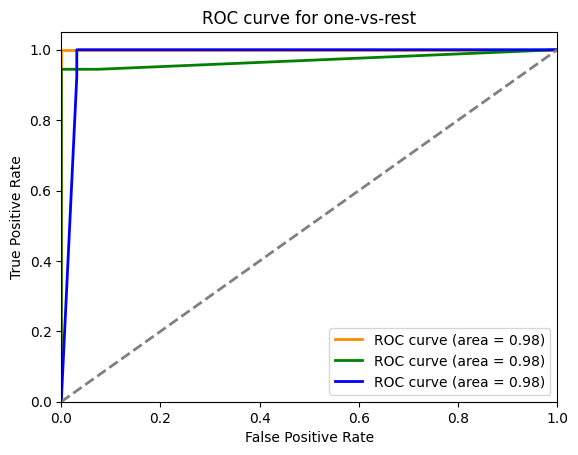

In [105]:
plt.figure()
lw = 2

plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)

plt.plot(
    fpr[1],
    tpr[1],
    color="green",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)

plt.plot(
    fpr[2],
    tpr[2],
    color="blue",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)

plt.plot([0, 1], [0, 1], color="grey", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for one-vs-rest")
plt.legend(loc="lower right")
plt.show()

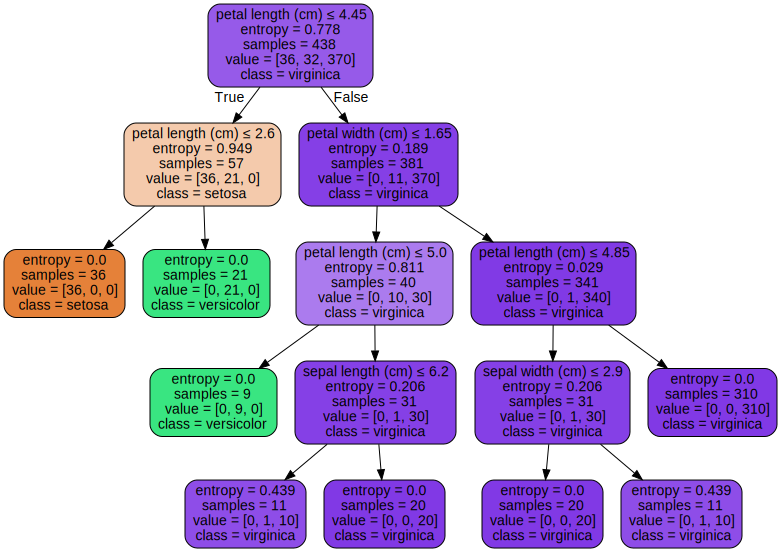

In [15]:
# initialize another classifier to visualize the graph on the total examples
clf_graph = clf_oversampling
clf_graph = clf_graph.fit(X_train_oversample, y_train_oversample)

dot_data = tree.export_graphviz(clf_graph, out_file=None, 
                                feature_names=iris.feature_names,
                                class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Weights Tree

In [57]:
clf_weights = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:10})
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=1)

clf_weights = clf_weights.fit(X_train, y_train)

predicted_y_test = clf_weights.predict(X_test)

fp, tp, fn, tn = 0, 0, 0, 0
for i in range(0,3):
	fp, tp, fn, tn = compute_fp_tp_fn_tn(y_test, predicted_y_test, i)
	print(f"accuracy_homemade for class {i}: {(tp+tn) / (tp+tn+fp+fn)}")
	print(f"precision for class {i}: {tp / (tp+fp)}")
	print(f"recall for class {i} : {tp / (tp+fn)}")
	print('\n')

print(f"accuracy: {accuracy_score(y_test, predicted_y_test)}")
f1 = f1_score(y_test, predicted_y_test, average='macro') # macro means that the score is calculated for each class and then averaged
print(f"f1 score: {f1}")

confusion_matrix(y_test, predicted_y_test)

accuracy_homemade for class 0: 1.0
precision for class 0: 1.0
recall for class 0 : 1.0


accuracy_homemade for class 1: 0.9777777777777777
precision for class 1: 1.0
recall for class 1 : 0.9444444444444444


accuracy_homemade for class 2: 0.9777777777777777
precision for class 2: 0.9285714285714286
recall for class 2 : 1.0


accuracy: 0.9777777777777777
f1 score: 0.9781305114638448


array([[14,  0,  0],
       [ 0, 17,  1],
       [ 0,  0, 13]], dtype=int64)

In [101]:
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:10}))

y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

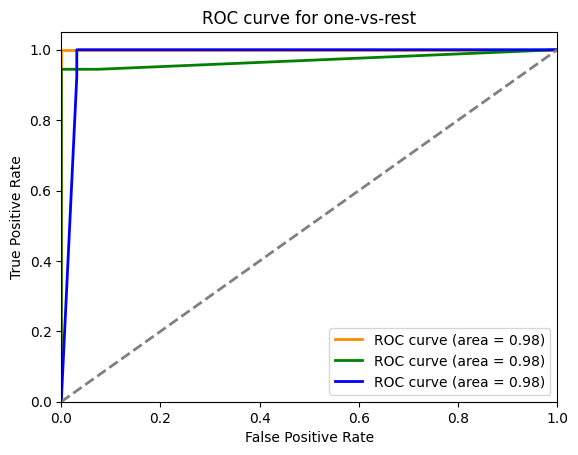

In [104]:
plt.figure()
lw = 2

plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)

plt.plot(
    fpr[1],
    tpr[1],
    color="green",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)

plt.plot(
    fpr[2],
    tpr[2],
    color="blue",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)

plt.plot([0, 1], [0, 1], color="grey", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for one-vs-rest")
plt.legend(loc="lower right")
plt.show()

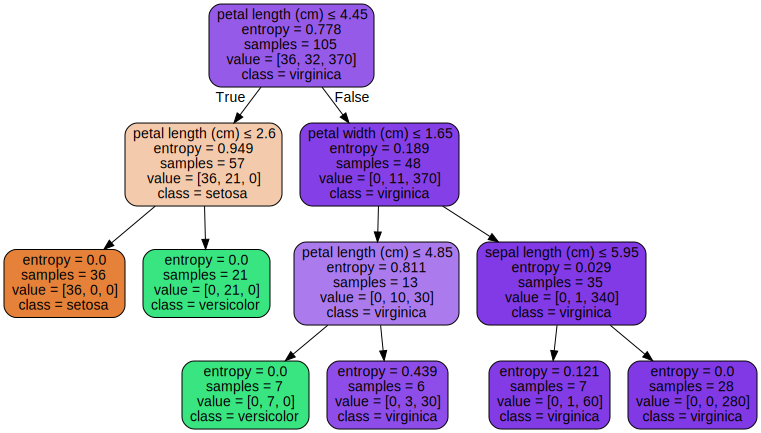

In [17]:
clf_graph = clf_weights
clf_graph = clf_graph.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf_graph, out_file=None, 
                                feature_names=iris.feature_names,
                                class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph